# Classification with `QNNClassifier`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNClassifier, CrossEntropyLoss
from squlearn.optimizers import SLSQP

In [2]:
executor = Executor("qulacs")

## Classifier Setup
Let's start by defining a PQC

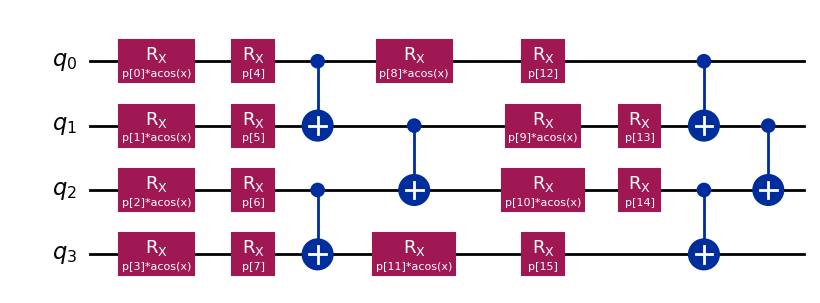

In [3]:
nqubits = 4
number_of_layers = 2
pqc = ChebyshevRx(num_qubits=nqubits, num_layers=number_of_layers)
pqc.draw("mpl", num_features=2)

Next, we also need a Expectation Operator

In [4]:
cost_op = SummedPaulis(nqubits)
print(cost_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


Now we're ready to define the `QNNClassifier` with randomly initialized parameters for the PQC and the Operator

In [5]:
np.random.seed(42)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(cost_op.num_parameters)

clf = QNNClassifier(
    pqc, cost_op, executor, CrossEntropyLoss(eps=1e-9), SLSQP(), param_ini, param_op_ini
)

## Generate Dataset

We use the `make_blobs` dataset from scikit-learn with 60 data points in two classes. We continue to scale the data and split it into a set for training and one for testing.

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = make_blobs(60, centers=2, random_state=0)
X = MinMaxScaler((-0.9, 0.9)).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Optimization

Now we're ready to fit the `QNNClassifier`.

In [7]:
clf.fit(X_train, y_train)

C:\Users\mow\Documents\AutoQML\squlearn\src\squlearn\qnn\lowlevel_qnn\lowlevel_qnn.py:69: UserWarning: Primitive argument is not supported for Qulacs. Ignoring...
  warn("Primitive argument is not supported for Qulacs. Ignoring...")


fit:  16%|█▌        | 16/100 [00:12<01:03,  1.32it/s]


## Evaluation
Let's check the trained parameters.

In [8]:
print("Result Param:", clf._param)
print("Result ParamOp:", clf._param_op)

Result Param: [ 0.016041    0.22915205 -0.00870477  1.06009097  0.04079803 -0.49602662
 -0.32010284  0.78106639  1.09974813  1.26803441 -0.07560963  1.43134234
  0.73658561 -0.44713065  0.11071829  0.09829475]
Result ParamOp: [-0.42471747  1.57643947  1.66216211  0.97154409  4.28380572]


Also, let's check the performance of the classifier on the test set using the mean accuracy.

In [9]:
clf.score(X_test, y_test)

1.0

Finally, let's visualize the classifiers performance. We plot the training and test set as well as the decision boundary of the `QNNClassifier`.

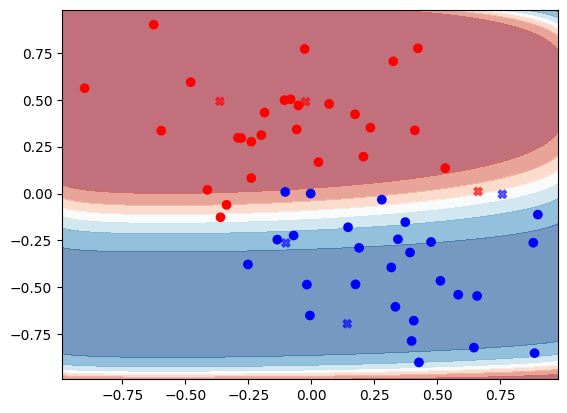

In [10]:
from matplotlib.colors import ListedColormap

xx, yy = np.meshgrid(np.arange(-0.99, 0.99, 0.01), np.arange(-0.99, 0.99, 0.01))

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.6)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, marker="X")